In [1]:
import sys
sys.path.append("..")
from functions.functions import * 

# Preprocessing

In [2]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess(file_paths)

# Feature Selection

In [5]:
# Selected Features
selected_features = ['minimum_nights', 
                     'number_of_reviews', 
                     'reviews_per_month', 
                     'calculated_host_listings_count', 
                     'availability_365',
                     'Host Response Rate', 
                     'Accommodates', 
                     'Bathrooms', 
                     'Bedrooms', 
                     'Beds', 
                     'Square Feet',
                     'recency_last_review' ,
                     'last_review_day', 
                     'last_review_month', 
                     'last_review_year', 
                     'room_type_Entire home/apt', 
                     'room_type_Private room', 
                     'room_type_Shared room',
                     'mean_target_neighbourhood',
                     'mean_target_neighbourhood_group',
                     'neighbourhood_group_Bronx', 
                     'neighbourhood_group_Brooklyn',
                     'neighbourhood_group_Manhattan',
                     'neighbourhood_group_Queens',
                     'neighbourhood_group_Staten Island',
                     'x', 
                     'y', 
                     'z',
                     'text_encoding_tsne_1',
                     'text_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
X_val_np = X_val_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()
y_val_np = y_val.to_numpy().flatten()

X_test_selected.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Host Response Rate,Accommodates,Bathrooms,Bedrooms,Beds,...,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,x,y,z,text_encoding_tsne_1,text_encoding_tsne_2
27357,3,4,2.45,1,23,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208824,-0.728089,0.652900,-7.517027,-0.076676
17998,1,35,2.75,10,156,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208893,-0.728482,0.652440,-7.517027,-0.076676
11703,3,16,0.62,4,37,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209660,-0.728891,0.651737,-7.517027,-0.076676
25026,1,0,0.00,10,284,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,0,1,0,0,0.208956,-0.727793,0.653188,-7.517027,-0.076676
31283,1,0,0.00,1,43,-2.0,-2.0,-2.0,-2.0,-2.0,...,0,1,0,0,0,0.209579,-0.728689,0.651989,-7.517027,-0.076676


# XGBOOST

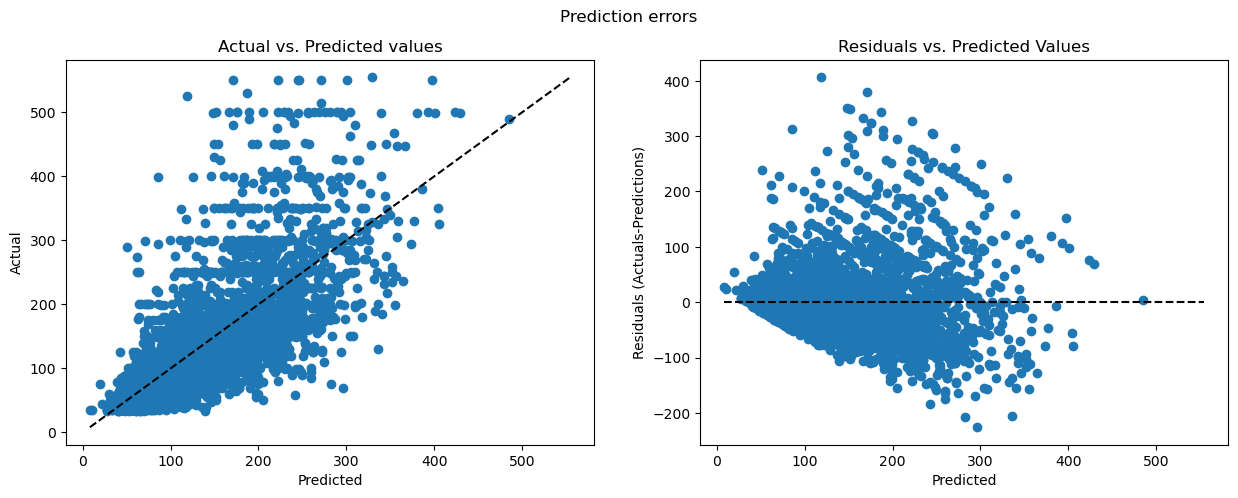

R²: 0.5433580249749688
MAE: 42.26777791673882
MSE: 4085.238901058515
RMSE: 63.91587362352575
MAPE: 0.3309704632680182
error_ratio_rmse: 0.4621221528733646
error_ratio_mae: 0.3056029030144879


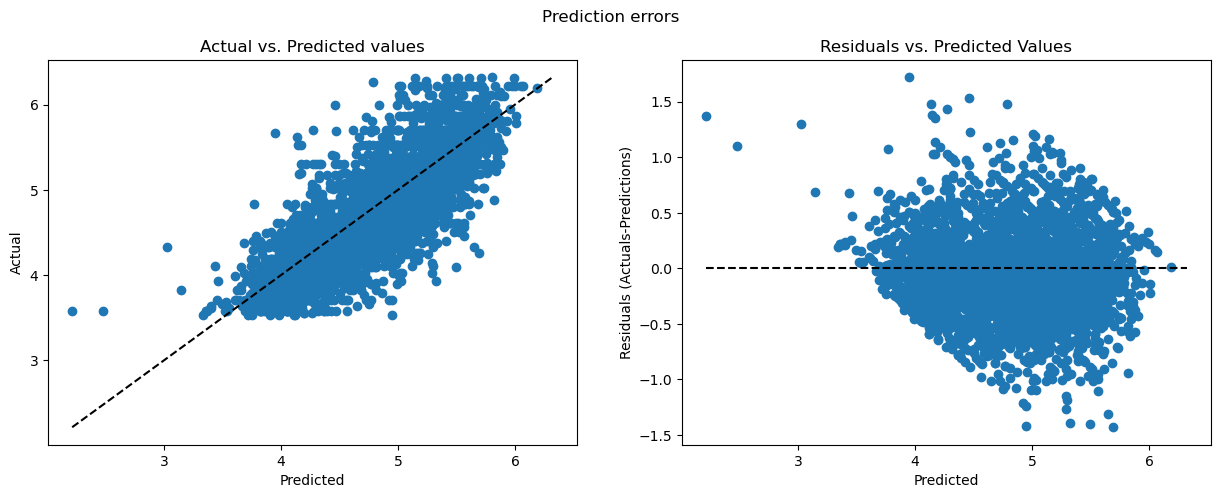

R²: 0.6239863234464429
MAE: 0.297672843949138
MSE: 0.14613033709050408
RMSE: 0.3822699793215576
MAPE: 0.06401641828160794
error_ratio_rmse: 0.0806795526965311
error_ratio_mae: 0.0628250011741542


In [6]:
model_init = xg.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse').fit(X_train_np, y_train_np)
y_pred = np.maximum(0,model_init.predict(X_test_np))

# score for price
model_init_score=scores(y_test_np,y_pred,plot= True)

# score for log_price
model_init_logscore=scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

#### Model Tuning

In [11]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,150),
        'learning_rate' : hp.uniform('learning_rate', 0.001,0.1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5,1),
        'colsample_bynode' : hp.uniform('colsample_bynode', 0.5,1),
        'subsample' : hp.uniform('subsample', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 600, 1),
        'seed': hp.quniform('seed', 0, 1000, 1)
    }

def objective(space):
    mod=xg.XGBRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=space['colsample_bytree'],
                          colsample_bylevel=space['colsample_bylevel'],
                          colsample_bynode=space['colsample_bynode'],
                          subsample=space['subsample'],
                          learning_rate=space['learning_rate'],
                          seed = int(space['seed']),
                          objective = 'reg:squarederror',
                          eval_metric = 'rmse'
                       )
    
    
    evaluation = [( X_train_np, y_train_np), ( X_val_np, y_val_np)]
    
    mod.set_params(eval_metric="rmse",early_stopping_rounds=10)
    mod.fit(X_train_np, y_train_np,eval_set=evaluation,verbose=False)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np, y_pred)['RMSE']
    print ("SCORE:", score)

    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.5455437248883206                                                                                                 
MAE: 42.268656733550564                                                                                                
MSE: 4065.685056251375                                                                                                 
RMSE: 63.76272466144601                                                                                                
MAPE: 0.32939465435220544                                                                                              
error_ratio_rmse: 0.46101486099023276                                                                                  
error_ratio_mae: 0.3056092570028479                                                                                    
SCORE:                                                                                                                 
63.76272466144601                       

MAE: 41.92190004165873                                                                                                 
MSE: 4656.692413738563                                                                                                 
RMSE: 68.23996199983235                                                                                                
MAPE: 0.29848315723642055                                                                                              
error_ratio_rmse: 0.4933860145150522                                                                                   
error_ratio_mae: 0.30310214977117395                                                                                   
SCORE:                                                                                                                 
68.23996199983235                                                                                                      
R²: -1.6934504232697862                 

MSE: 3944.0061754274957                                                                                                
RMSE: 62.80132303883013                                                                                                
MAPE: 0.31657256109465465                                                                                              
error_ratio_rmse: 0.4540637710272589                                                                                   
error_ratio_mae: 0.297247562168915                                                                                     
SCORE:                                                                                                                 
62.80132303883013                                                                                                      
R²: 0.5599173753377098                                                                                                 
MAE: 41.0418478435296                   

RMSE: 62.65260457591975                                                                                                
MAPE: 0.31505337464270083                                                                                              
error_ratio_rmse: 0.45298851237309473                                                                                  
error_ratio_mae: 0.2965292668721837                                                                                    
SCORE:                                                                                                                 
62.65260457591975                                                                                                      
R²: 0.53357340741119                                                                                                   
MAE: 42.67776828142911                                                                                                 
MSE: 4172.774656616989                  

MAPE: 0.3136914630757106                                                                                               
error_ratio_rmse: 0.45154514573689236                                                                                  
error_ratio_mae: 0.29543345206514643                                                                                   
SCORE:                                                                                                                 
62.452973290255756                                                                                                     
R²: -1.3348114448854767                                                                                                
MAE: 114.20689200986054                                                                                                
MSE: 20887.835685188467                                                                                                
RMSE: 144.52624566212347                

error_ratio_rmse: 0.6307180659554155                                                                                   
error_ratio_mae: 0.38481702888817054                                                                                   
SCORE:                                                                                                                 
87.23428631374843                                                                                                      
R²: 0.5657230058490292                                                                                                 
MAE: 40.665670134540946                                                                                                
MSE: 3885.1559150756048                                                                                                
RMSE: 62.33101888366341                                                                                                
MAPE: 0.31314483778140595               

error_ratio_mae: 0.30346378714849936                                                                                   
SCORE:                                                                                                                 
63.72623184333698                                                                                                      
R²: 0.5648047335579531                                                                                                 
MAE: 40.809969659864855                                                                                                
MSE: 3893.371019885151                                                                                                 
RMSE: 62.3968830943113                                                                                                 
MAPE: 0.3143531753904447                                                                                               
error_ratio_rmse: 0.4511396045053414    

In [10]:
best_hyperparams = {'colsample_bylevel': 0.825748223143875,
                     'colsample_bynode': 0.5135760138909693,
                     'colsample_bytree': 0.8134127661562701,
                     'gamma': 4.784232493741881,
                     'learning_rate': 0.03155275118849707,
                     'max_depth': 8.0,
                     'min_child_weight': 3.0,
                     'n_estimators': 535.0,
                     'reg_alpha': 99.0,
                     'reg_lambda': 0.5150219874806119,
                     'seed': 645.0,
                     'subsample': 0.9018474795540982}

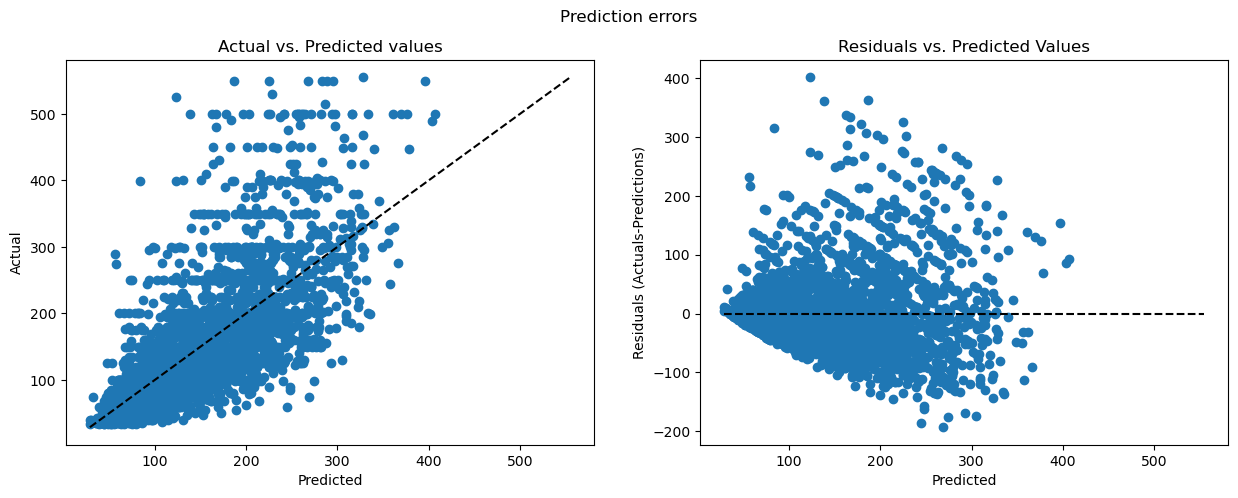

R²: 0.5698804077601658
MAE: 40.756570707997355
MSE: 3847.9627069528105
RMSE: 62.03194908233023
MAPE: 0.31542625235815186
error_ratio_rmse: 0.4485010722955378
error_ratio_mae: 0.2946766293183038


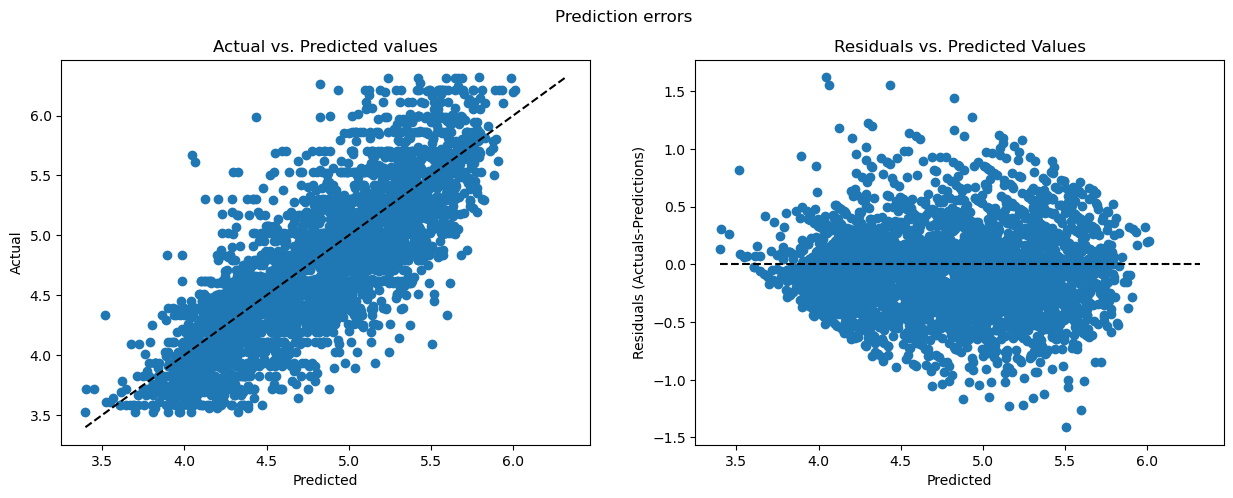

R²: 0.6580968922617856
MAE: 0.284151881666716
MSE: 0.132873933852669
RMSE: 0.3645187702336726
MAPE: 0.061019206643286195
error_ratio_rmse: 0.0769330915918037
error_ratio_mae: 0.05997134996432466


In [11]:
model_tuned = xg.XGBRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          colsample_bylevel=best_hyperparams['colsample_bylevel'],
                          colsample_bynode=best_hyperparams['colsample_bynode'],
                          subsample=best_hyperparams['subsample'],
                          learning_rate=best_hyperparams['learning_rate'],
                          seed = int(best_hyperparams['seed']),
                          objective = 'reg:squarederror',
                          eval_metric = 'rmse'
                       )


model_tuned.fit(X_train_np, y_train_np,verbose=False)

y_pred = np.maximum(0,model_tuned.predict(X_test_np))
model_tuned_score = scores(y_test_np,y_pred,plot=True)
model_tuned_logscore= scores(np.log(y_test_np+1),np.log(y_pred+1),plot= True)

In [13]:
# save model to JSON and load it
model_tuned.save_model("saved_models/xgb_model.json")

with open('saved_models/xgb_params.json', 'w') as f:
    json.dump(model_tuned.get_params(), f)